In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import datetime
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import timm

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import PIL
from PIL import Image as image

from Dataloader import dataloader, SquarePad, load_split_train_vaild, setseed
from utils import reshape, drawimg, tensor_to_pltimg, multidrawimg
from utils_traintest import train, test

In [17]:
# Training Device Setting
setseed(42)
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


### Dataloader

In [18]:
data_path = './trainvalid'
# Check data shape
os.getcwd()
image = PIL.Image.open(f"{data_path}/0/0021.jpg")
width, height = image.size
print(width, height)

2880 2136


In [19]:
#DataLoad
data_path = './trainvalid/'
train_transforms = transforms.Compose([SquarePad(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(), 
                                       ])
trainl, validl= load_split_train_vaild(data_path, train_transforms, valid_size=.2, batch_size=4)

943 236 1179 1179


torch.Size([3, 224, 224])


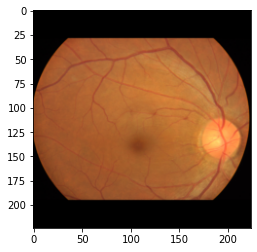

236

In [20]:
print(trainl.dataset[10][0].size())
plt.imshow(np.uint8(trainl.dataset[0][0].permute(1,2,0)*255))
plt.show()
len(validl.dataset)

In [21]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [22]:
model = timm.create_model('resnet10t')
model.conv1 = nn.Conv2d(3, 64, kernel_size=224, stride=2, padding=3, bias=False)
# model = model.to('cuda')
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 10
total_df = pd.DataFrame()
seedlist = [*range(10)]
for seed in seedlist:
    setseed(seed)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        traindf = train(trainl, model, loss_fn, optimizer,device=device, epoch=int(t), seed=seed)
        validdf = test(validl, model, loss_fn, device=device, epoch=int(t), seed=seed)
        total_df = pd.concat([total_df, traindf])
        total_df = pd.concat([total_df, validdf])
    
print("Done!")

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")
total_df = total_df.reset_index()


Epoch 1
-------------------------------


TypeError: train() got an unexpected keyword argument 'seed'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

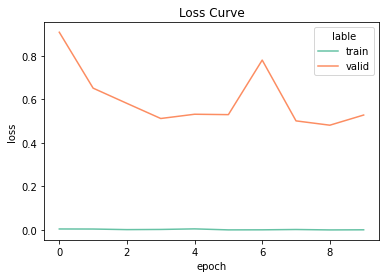

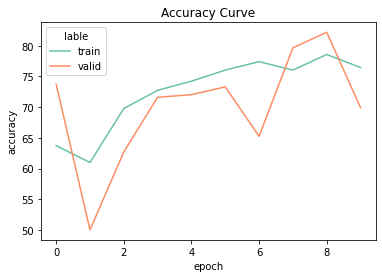

In [8]:
plt.title('Loss Curve')
sns.lineplot(data=total_df,x='epoch',y='loss',hue='lable',palette="Set2")
plt.show()
plt.title('Accuracy Curve')
sns.lineplot(data=total_df,x='epoch',y='accuracy',hue='lable',palette="Set2")
plt.show()

In [9]:
data_path_t = './test/'
test_transforms = transforms.Compose([transforms.ToTensor()])
dataset_t = datasets.ImageFolder(data_path_t, transform=test_transforms)
testloader = DataLoader(dataset_t, batch_size=4,shuffle=False)

In [12]:
model = timm.create_model('resnet10t')
model.conv1 = nn.Conv2d(3, 64, kernel_size=224, stride=2, padding=3, bias=False)
model.load_state_dict(torch.load("model.pth"))
test(testloader, model, loss_fn, device=device, valid=False, epoch=None)

0
3000
1
2000
2000
1001
3000
2001
0


KeyboardInterrupt: 

In [53]:
import csv
def test_(dataloader, model, loss_fn, device, valid=True):
    model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        if valid:
            for X, y in dataloader:
                X, y = X.to(device).float(), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        elif valid == False:
            counter = 0
            filename = f"Submissions/Submission_{counter}.csv"
            while os.path.exists(filename):
                counter += 1
                filename = f"Submissions/Submission_{counter}.csv"
            with open(filename, 'a+', newline='') as f:  # 'a+' means append to a file
                thewriter = csv.writer(f)
                for X, y in dataloader:
                    X = X.to(device).float()
                    pred = model(X)
                    result = pred.argmax().item()  # this your label
                    print(pred, result)
                    thewriter.writerow([result])
                    break